In [ ]:
pip install torch

In [ ]:
pip install torchvision

In [3]:
import numpy as np
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import struct
import os
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset
import pickle

In [1]:
# the data originally is a list with size ~90 x 4. the data is processed to just get the 15 readings around the first spike in proximity values, and 2 features are added to the list, the differences between up and down and the differences between right and left readings
def process(dataList):
    dataList = [p[0:4] for p in dataList]
    dataList = [[int(elem) for elem in p] for p in dataList]

    if(len(dataList) < 15):
        return None
    
    for j in range(0, len(dataList)): # adds the 2 other features
        dataList[j].append(dataList[j][0] - dataList[j][1])
        dataList[j].append(dataList[j][2] - dataList[j][3])
        
        

    for thresh in range(30, 15, -1): # looks for the earliest peak of 30 and gets the 15 data points around it. if it cant find any value higher than 30, then try 29. keep trying until you reach 15. if nothing, then return None
        num = -1
        for i in range(len(dataList)):
            for j in range(0, 4):
                if dataList[i][j] > thresh:
                    num = i
                    break
        
        if num == -1:
            continue

        if num + 10 < len(dataList) and num - 5 > 0:
            return dataList[num-5:num+10]
        if num -5 > 0:
            return dataList[-16:-1]
        return dataList[0:15]
    
    return None


In [ ]:
# opens all the files and puts them into a list called myData. also depending on which folder the file comes from, adds a label 0, 1, 2, 3, or 4 to the list myLabels
myData = []
myLabels = []
for i in range(1, 1000):
    with open('left/left_' + str(i) + '.csv', newline = '') as csvfile: # if the data is not already in the python folder for the neuralnetwork, put it in there
        f = list(csv.reader(csvfile))
        g = process(f)
        if (g != None):
            myData.append(g)
            myLabels.append(1)

for i in range(1, 1000):
    with open('right/right_' + str(i) + '.csv', newline = '') as csvfile:
        f = list(csv.reader(csvfile))
        g = process(f)
        if (g != None):
            myData.append(g)
            myLabels.append(3)
for i in range(1, 1000):
    with open('up/up_' + str(i) + '.csv', newline = '') as csvfile:
        f = list(csv.reader(csvfile))
        g = process(f)
        if (g != None):
            myData.append(g)
            myLabels.append(0)
for i in range(1, 1000):
    with open('down/down_' + str(i) + '.csv', newline = '') as csvfile:
        f = list(csv.reader(csvfile))
        g = process(f)
        if (g != None):
            myData.append(g)
            myLabels.append(2)    
for i in range(105, 1104):
    with open('nothing/nothing_' + str(i) + '.csv', newline = '') as csvfile:
        f = list(csv.reader(csvfile))
        g = process(f)
        if (g != None):
            myData.append(g)
            myLabels.append(4)    

for i in range(0, len(myData)):
    if (len(myData[i]) != 15):
        print(i)




In [5]:
# splits the data into 60% for training, 20% for validation, 20% for the final test using % 
myTrainData = [myData[i] for i in range(0, len(myData)) if i % 5 != 0 and i % 5 != 3]
myTrainLabels = [myLabels[i] for i in range(0, len(myData)) if i % 5 != 0 and i % 5 != 3]
myTestData = [myData[i] for i in range(0, len(myData)) if i % 5 == 0]
myTestLabels = [myLabels[i] for i in range(0, len(myData)) if i % 5 == 0]
myFinalTestData = [myData[i] for i in range(0, len(myData)) if i % 5 == 3]
myFinalTestLabels = [myLabels[i] for i in range(0, len(myData)) if i % 5 == 3]

In [6]:
# converts the data, which are in lists, into arraylists
myTrainDataNP = np.array(myTrainData)
myTrainLabelsNP = np.array(myTrainLabels)
myTestDataNP = np.array(myTestData)
myTestLabelsNP = np.array(myTestLabels)
myFinalTestDataNP = np.array(myFinalTestData)
myFinalTestLabelsNP = np.array(myFinalTestLabels)

print((type)(myTrainDataNP))
print(np.shape(myTrainDataNP))
print(np.shape(myTrainLabelsNP))
print(np.shape(myTestDataNP))
print(np.shape(myTestLabelsNP))
print(np.shape(myFinalTestDataNP))
print(np.shape(myFinalTestLabelsNP))

<class 'numpy.ndarray'>
(2819, 15, 6)
(2819,)
(940, 15, 6)
(940,)
(940, 15, 6)
(940,)


In [7]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert the image to a float tensor and normalize it
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # Add channel dimension and normalize
        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transform
transform = transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
# Create datasets
train_dataset = MNISTDataset(myTrainDataNP, myTrainLabelsNP, transform=transform)
test_dataset = MNISTDataset(myTestDataNP, myTestLabelsNP, transform=transform)

# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
#Define the simple neural network without hidden layers
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(6 * 15, 5)  # Input size 784, output size 10 (for digits 0-9)

    def forward(self, x):
        x = x.view(-1, 6 * 15)  # Flatten the image from (28, 28) to (784,1)

        return self.linear(x)

# Create an instance of the model
model = SimpleNet()

In [14]:
#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.0002) # 0.0005

In [10]:
final_test_dataset = MNISTDataset(myFinalTestDataNP, myFinalTestLabelsNP, transform=transform)
finaltestloader = DataLoader(final_test_dataset, batch_size=1, shuffle=True)

Epoch [1/5], Loss: 0.7293, Training Accuracy: 84.46%, Test Accuracy: 86.06%
Epoch [2/5], Loss: 0.7224, Training Accuracy: 84.46%, Test Accuracy: 85.43%
Epoch [3/5], Loss: 0.7163, Training Accuracy: 84.46%, Test Accuracy: 85.64%
Epoch [4/5], Loss: 0.7105, Training Accuracy: 84.46%, Test Accuracy: 85.21%
Epoch [5/5], Loss: 0.7043, Training Accuracy: 84.60%, Test Accuracy: 86.49%
Final Test Accuracy: 85.53%


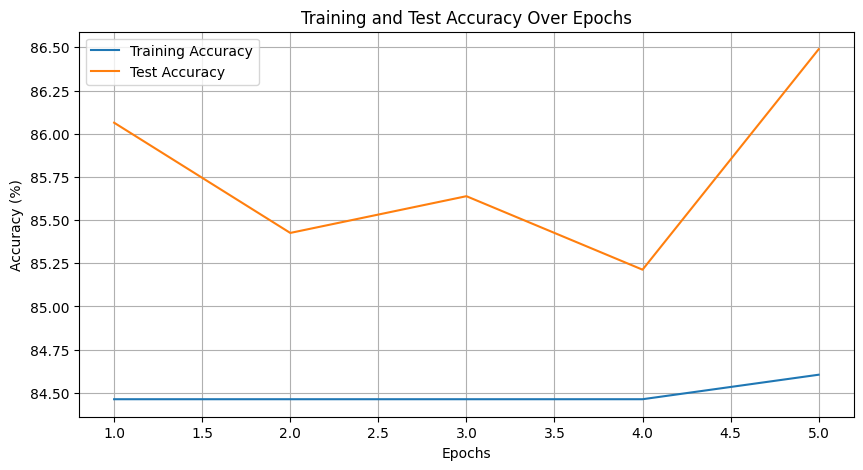

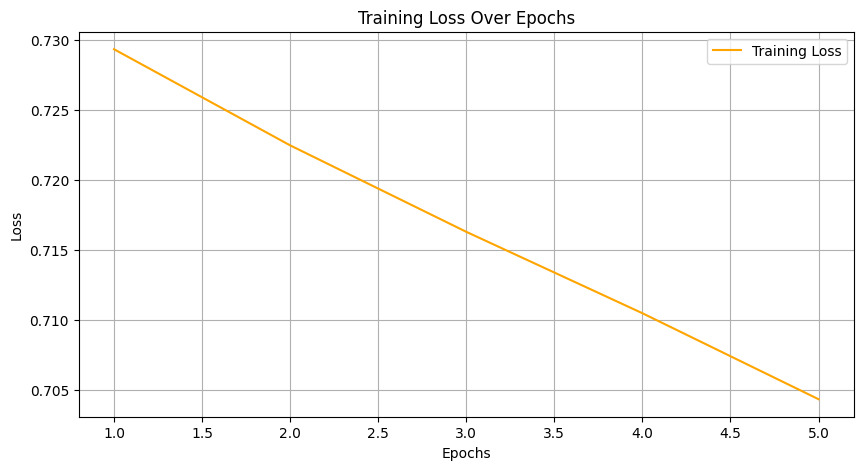

In [15]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Lists to store accuracy and loss values for plotting
train_accuracies = []
test_accuracies = []
train_losses = []

# Train the model and store training/test accuracy and loss
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()  # Set the model to training mode
    # print(trainloader)
    for images, labels in trainloader:
        optimizer.zero_grad()  # Clear previous gradients
        
        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total

    # Store the loss and accuracy
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Calculate test accuracy
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    with torch.no_grad():  # No gradient computation during testing
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)

    # Print training loss, training accuracy, and test accuracy for the epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

totalw = 0
totala = 0
totals = 0
totald = 0
totalnothing = 0

totalpw = 0
totalpa = 0
totalps = 0
totalpd = 0
totalpnothing = 0


with torch.no_grad():  # No gradient computation during testing
    for images, labels in finaltestloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if predicted == 0:
            totalpw += 1
        if predicted == 1:
            totalpa += 1
        if predicted == 2:
            totalps += 1
        if predicted == 3:
            totalpd += 1
        if predicted == 4:
            totalpnothing += 1
        if labels == 0:
            totalw += 1
        if labels == 1:
            totala += 1
        if labels == 2:
            totals += 1
        if labels == 3:
            totald += 1
        if labels == 4:
            totalnothing += 1
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
# those print statements were used to see if a certain gesture would be predicted more often than others
# print(totalw)
# print(totalpw)
# print(totala)
# print(totalpa)
# print(totals)
# print(totalps)
# print(totald)
# print(totalpd)
# print(totalnothing)
# print(totalpnothing)

test_accuracy = 100 * test_correct / test_total

print(f'Final Test Accuracy: {test_accuracy:.2f}%')

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
with open('newmodeltest.pkl', 'wb') as f:
    pickle.dump(model, f)

In [12]:
with open('modelwithnothing.pkl', 'rb') as f:
    model = pickle.load(f)
model.eval()

SimpleNet(
  (linear): Linear(in_features=90, out_features=5, bias=True)
)

## Neural Network with one hidden layer

A hidden layer in a neural network is a layer of neurons located between the input and output layers. It allows the network to learn and represent more complex patterns and relationships in the data by introducing non-linear transformations.

In [17]:
class SimpleNetWithHiddenLayer(nn.Module):
    def __init__(self):
        super(SimpleNetWithHiddenLayer, self).__init__()
        self.hidden = nn.Linear(6 * 15, 5)  # Input size 90, hidden layer size 5
        self.relu = nn.ReLU()                 # ReLU activation function
        self.output = nn.Linear(5, 5)      # Output layer for 5 classes

    def forward(self, x):
        x = x.view(-1, 6 * 15)  # Flatten the input image from (15, 6) to (90,)
        x = self.relu(self.hidden(x))  # Apply hidden layer and ReLU activation
        x = self.output(x)             # Apply output layer
        return x
model = SimpleNetWithHiddenLayer()

In [28]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.SGD(model.parameters(), lr=0.002)

Number of images in the training set: 2819
Number of images in the test set: 940
Epoch [1/5], Loss: 0.5551, Training Accuracy: 87.94%, Test Accuracy: 88.19%
Epoch [2/5], Loss: 0.5179, Training Accuracy: 88.05%, Test Accuracy: 88.94%
Epoch [3/5], Loss: 0.4897, Training Accuracy: 88.58%, Test Accuracy: 87.45%
Epoch [4/5], Loss: 0.4703, Training Accuracy: 87.97%, Test Accuracy: 88.62%
Epoch [5/5], Loss: 0.4539, Training Accuracy: 88.19%, Test Accuracy: 88.51%
194
Final Test Accuracy: 88.35%


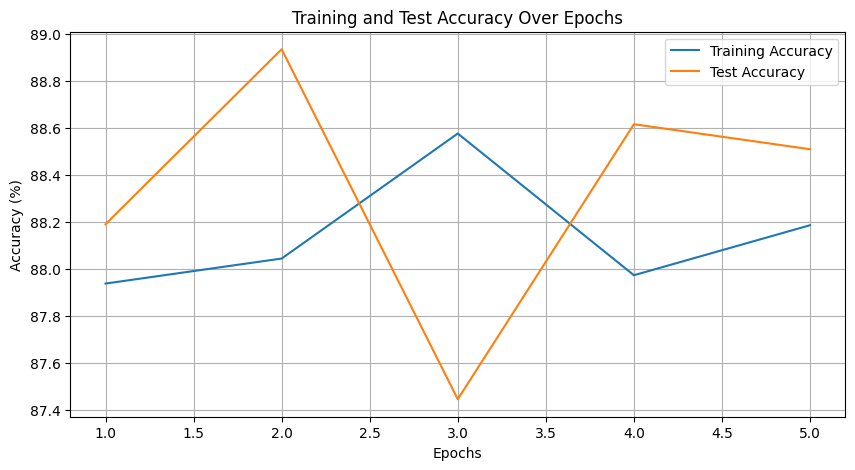

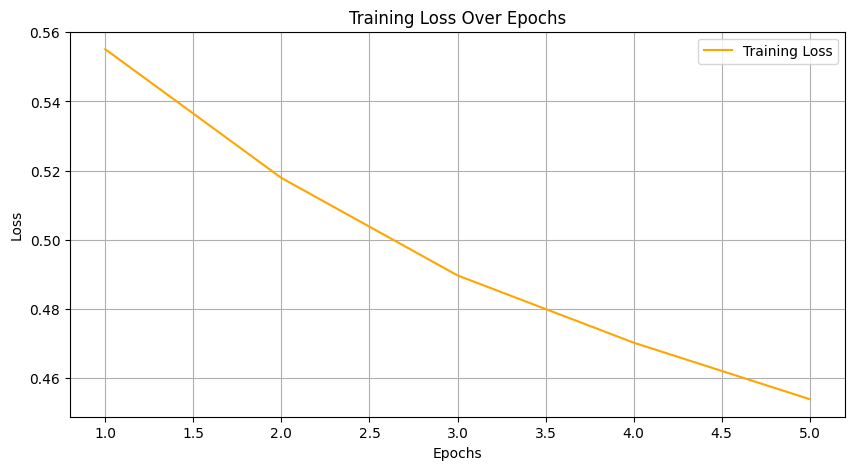

In [29]:
# Create DataLoaders
trainloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
# Print the number of images in the training and test sets
print(f'Number of images in the training set: {len(train_dataset)}')
print(f'Number of images in the test set: {len(test_dataset)}')

# Lists to store accuracy and loss values for plotting
train_accuracies = []
test_accuracies = []
train_losses = []

#Define the neural network with a hidden layer

# Create an instance of the model


#Define the loss function and optimizer
totalw = 0
totala = 0
totals = 0
totald = 0
totalnothing = 0

totalpw = 0
totalpa = 0
totalps = 0
totalpd = 0
totalpnothing = 0

ivxv = 0

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()  # Set the model to training mode
    for images, labels in trainloader:
        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total

    # Store the loss and accuracy
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Calculate test accuracy
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    with torch.no_grad():  # No gradient computation during testing
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)

    # Print training loss, training accuracy, and test accuracy for the epoch
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')


with torch.no_grad():  # No gradient computation during testing
    for images, labels in finaltestloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if predicted == 0:
            totalpw += 1
        if predicted == 1:
            totalpa += 1
        if predicted == 2:
            totalps += 1
        if predicted == 3:
            totalpd += 1
        if predicted == 4:
            totalpnothing += 1
        if labels == 0:
            totalw += 1
        if labels == 1:
            totala += 1
        if labels == 2:
            totals += 1
        if labels == 3:
            totald += 1
        if labels == 4:
            totalnothing += 1
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# those print statements were used to see if a certain gesture would be predicted more often than others    
# print(totalw)
# print(totalpw)
# print(totala)
# print(totalpa)
# print(totals)
# print(totalps)
# print(totald)
# print(totalpd)
# print(totalnothing)
print(totalpnothing)
test_accuracy = 100 * test_correct / test_total

print(f'Final Test Accuracy: {test_accuracy:.2f}%')

# Plot the training and test accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
with open('hiddenlayermodel.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
with open('hiddenlayermodel.pkl', 'rb') as f:
    model = pickle.load(f)
model.eval()

SimpleNetWithHiddenLayer(
  (hidden): Linear(in_features=90, out_features=5, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=5, out_features=5, bias=True)
)

In [19]:
testable = np.zeros((5, 5))
model.eval()
with torch.no_grad():  # No gradient computation during testing
    for images, labels in finaltestloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        testable[labels][predicted] += 1

accuraciesAndF1s = np.zeros((5, 2))

for i in range(0, 5):
    total = testable.sum()
    TP = testable[i,i]
    FP = testable[:, i].sum() - TP
    FN = testable[i, :].sum() - TP
    TN = total - FP - FN - TP
    P = TP + FN
    N = FP + TN
    PPV = TP / (TP + FP)
    TPR = TP / P
    ACC = (TP + TN) / (total)
    F1 = 2 * (PPV * TPR / (PPV + TPR))
    accuraciesAndF1s[i, 0] = ACC
    accuraciesAndF1s[i, 1] = F1
    
print("Test results: ")
print(testable)
print()
print("Accuracies and F1 Scores: ")
print(accuraciesAndF1s)
print()
print("Total Accuracy: ")
print(np.array([testable[i,i] for i in range(0, 5)]).sum() / testable.sum())
print()
print("F1 Average: ")
print(accuraciesAndF1s[:, 1].sum() / 5)

Test results: 
[[180.   7.   1.   9.   2.]
 [  9. 162.  12.   1.   0.]
 [  1.   9. 148.  15.   0.]
 [  6.  17.  15. 146.   0.]
 [  9.   1.   0.   1. 189.]]

Accuracies and F1 Scores: 
[[0.95319149 0.89108911]
 [0.94042553 0.85263158]
 [0.94361702 0.84813754]
 [0.93191489 0.82022472]
 [0.98617021 0.96675192]]

Total Accuracy: 
0.8776595744680851

F1 Average: 
0.8757669721869139
